# 1. パッケージのインストール、パラメータの設定

In [1]:
!pip install opencv-python

    100% |████████████████████████████████| 25.0MB 39kB/s eta 0:00:011    70% |██████████████████████▊         | 17.7MB 1.7MB/s eta 0:00:05
Requirement not upgraded as not directly required: numpy>=1.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from opencv-python)


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

net_h, net_w = 416, 416
anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326]
obj_thresh, nms_thresh = 0.5, 0.45
labels = ["watson","watson_others"]

# 2. テスト画像の読み込み
テスト用の画像をダウンロードして、WML上のWebサービスの形式に整形

In [3]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)//new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)//new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (new_w, new_h))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[(net_h-new_h)//2:(net_h+new_h)//2, (net_w-new_w)//2:(net_w+new_w)//2, :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

In [4]:
!wget http://www.internetman.jp/main/wp-content/uploads/2016/03/Watson-0218-01-1024x594.jpg

--2018-09-21 02:08:10--  http://www.internetman.jp/main/wp-content/uploads/2016/03/Watson-0218-01-1024x594.jpg
Resolving www.internetman.jp (www.internetman.jp)... 103.15.186.10
Connecting to www.internetman.jp (www.internetman.jp)|103.15.186.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126792 (124K) [image/jpeg]
Saving to: ‘Watson-0218-01-1024x594.jpg’

100%[======================================>] 126,792      159KB/s   in 0.8s   

2018-09-21 02:08:11 (159 KB/s) - ‘Watson-0218-01-1024x594.jpg’ saved [126792/126792]



In [5]:
image = cv2.imread('Watson-0218-01-1024x594.jpg')
score_payload_data = preprocess_input(image, net_h, net_w) 
score_payload_data = score_payload_data.tolist() 
payload_scoring = {"values": score_payload_data}

# 3.  Webサービスの呼び出し
- Code Snippetsからpythonのコードをコピペ
- wml_credential には WML の Credential を設定
- payload_scoring の行はコメントアウト

In [6]:
import urllib3, requests, json

# retrieve your wml_service_credentials_username, wml_service_credentials_password, and wml_service_credentials_url from the
# Service credentials associated with your IBM Cloud Watson Machine Learning Service instance

wml_credentials={
    "url": "https://ibm-watson-ml.mybluemix.net",
    "username": "xxxxxxxxxxxxxxxxx",
    "password": "xxxxxxxxxxxxxxxxx"
}

headers = urllib3.util.make_headers(basic_auth='{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
###payload_scoring = {"fields": [array_of_feature_columns], "values": [array_of_values_to_be_scored, another_array_of_values_to_be_scored]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/v3/wml_instances/6d23b778-bb30-43b4-9e0e-2bfcfeefc75f/deployments/41a6f21c-c0e2-4296-8abb-00f7ac4a4d83/online', json=payload_scoring, headers=header)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{'values': [[[[[0.08260131627321243, -1.5380449295043945, -0.31808048486709595, 0.23570893704891205, -8.096858978271484, -1.6649119853973389, 2.539419412612915, 1.4189857244491577, -0.028708668425679207, 1.1842360496520996, 1.7087914943695068, -8.78002643585205, -1.717315912246704, 0.3524625599384308, 0.3027600049972534, 0.5925307273864746, -0.29782065749168396, -0.9358639717102051, -11.404239654541016, -0.18325307965278625, -5.582236289978027], [1.006130576133728, 0.034953925758600235, -1.1095151901245117, 1.1114647388458252, -11.529048919677734, -2.9322826862335205, -0.3541303277015686, -0.25199300050735474, -1.622767686843872, 1.5133581161499023, 3.6683549880981445, -12.800293922424316, -0.36831915378570557, 3.7813680171966553, -3.89864444732666, 0.7456512451171875, 0.3024177849292755, -1.2915098667144775, -11.895232200622559, 1.3821470737457275, -5.870652198791504], [0.9994693398475647, 0.5771098732948303, -1.34603750705719, -0.5964200496673584, -13.224387168884277

In [7]:
dic1 = json.loads(response_scoring.text)
list1 = dic1.get('values')

# 4. 物体検出の結果表示
https://github.com/experiencor/keras-yolo3 からコードをダウンロードして利用

In [8]:
!git clone https://github.com/experiencor/keras-yolo3.git

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 168 (delta 2), reused 2 (delta 2), pack-reused 165
Receiving objects: 100% (168/168), 73.77 KiB | 0 bytes/s, done.
Resolving deltas: 100% (98/98), done.


In [9]:
mv keras-yolo3/* .

In [10]:
from utils.utils import _sigmoid, decode_netout, correct_yolo_boxes, do_nms, _softmax

def get_yolo_boxes(list1, images, net_h, net_w, anchors, obj_thresh, nms_thresh):
    image_h, image_w, _ = images[0].shape
    nb_images           = len(images)
    
    # run the prediction
    batch_output = list1
    batch_boxes  = [None]*nb_images

    for i in range(nb_images):
        yolos = [batch_output[0][i], batch_output[1][i], batch_output[2][i]]
        boxes = []

        # decode the output of the network
        for j in range(len(yolos)):
            yolo_anchors = anchors[(2-j)*6:(3-j)*6]
            boxes += decode_netout(np.array(yolos[j]), yolo_anchors, obj_thresh, net_h, net_w)

        # correct the sizes of the bounding boxes
        correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

        # suppress non-maximal boxes
        do_nms(boxes, nms_thresh)        
           
        batch_boxes[i] = boxes

    return batch_boxes 

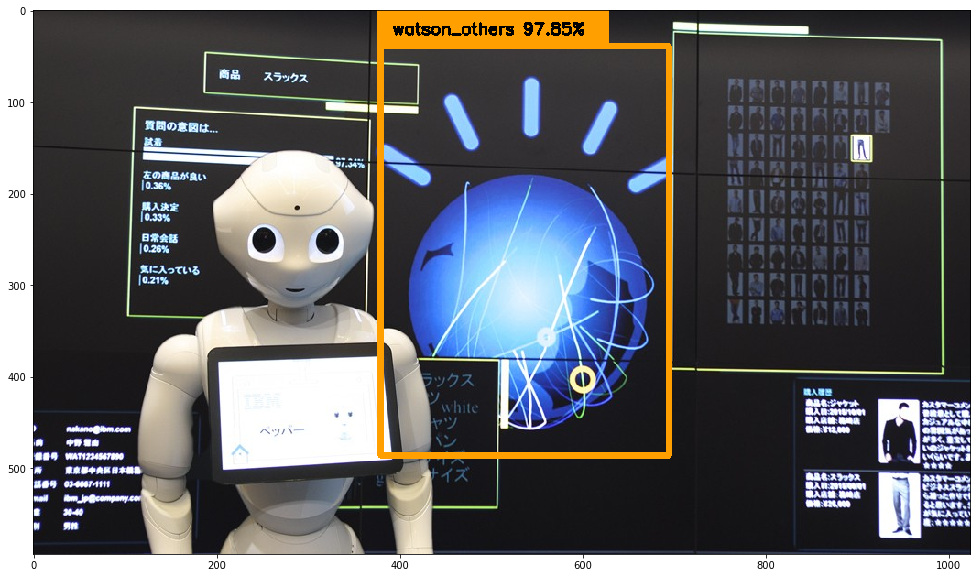

In [11]:
from utils.bbox import draw_boxes

boxes = get_yolo_boxes(list1, [image], net_h, net_w, anchors, obj_thresh, nms_thresh)[0]
draw_boxes(image, boxes, labels, obj_thresh) 
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))